In [1]:
!pip install nilearn 
# Download the standalone module if not using BrainIAK
from urllib.request import urlretrieve
urlretrieve('https://github.com/eyalhizmi/Machine-learning-methods-for-fMRI-signal-analysis/'
            'raw/main/tutorials/isc_standalone.py', 'isc_standalone.py');

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### ISC and ISFC Tutorial 
The goal of the tutorial is to introduce basic intersubject correlation (ISC) analyses [Hasson et al., 2004] and intersubject functional correlation (ISFC) [Simmony et al., 2016] 

In [2]:
from isc_standalone import (isc, isfc,
                            compute_summary_statistic, load_images,squareform_isfc,
                            load_boolean_mask, mask_images,
                            MaskedMultiSubjectData) 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, pearsonr, zscore
from scipy.spatial.distance import squareform
import nibabel as nib

## Example data
We'll create a simple simulated dataset for quickly applying ISC analyses, then later apply the analyses to a real fMRI dataset where participants listened to a spoken narrative ([Pie Man](https://themoth.org/stories/pie-man) by Jim O'Grady). Our simulated data will have 1,000 voxels in total comprising 10 "networks" and 300 time points (or TRs).

In [4]:
# Set parameters for toy time series data
n_subjects = 20
n_TRs = 300
n_voxels = 1000

# Create simple simulated data with high intersubject correlation
def simulated_timeseries(n_subjects, n_TRs, n_voxels=1, noise=1):
  signal = np.random.randn(n_TRs, n_voxels // 100)
  data = [zscore(np.repeat(signal, 100, axis=1) +
                 np.random.randn(n_TRs, n_voxels) * noise,
                 axis=0)
          for subject in np.arange(n_subjects)]
  return data

# List of subject datasets
data = simulated_timeseries(n_subjects, n_TRs, n_voxels=n_voxels)

Simulated data shape first subject: (300, 1000) 
i.e., 300 time points and 1000 voxels


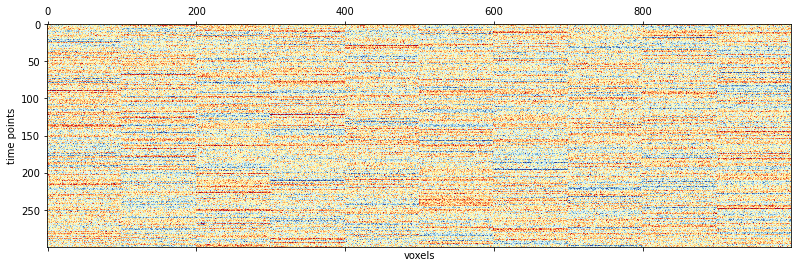

In [5]:
# Inspect the shape of one of our simulated datasets
print(f"Simulated data shape first subject: {data[0].shape} "
      f"\ni.e., {data[0].shape[0]} time points and {data[0].shape[1]} voxels")

# Create a simple visualization of the data
plt.matshow(data[0], cmap='RdYlBu_r', vmin=-3, vmax=3)
plt.grid(False)
plt.xlabel('voxels')
plt.ylabel('time points');

## ISC analysis and Pearson Correlation
Let's start very simple by computing the ISC for a single voxel (or ROI) across only two participants. This should give us a simple Pearson correlation value (and should match other implementations of Pearson correlation). Note that when you call the `isc` function with `verbose=True` (the default), it outputs some warnings describing what it infers about the input data. If these don't match your assumptions, your input data may be organized improperly.

In [6]:
# Get the time series for a single voxel in two subjects
subject_a = data[0][:, 0]
subject_b = data[1][:, 0]

# Check the shape of these mini-datasets
print(f"Subject A, first voxel, shape = {subject_a.shape} "
      f"\nSubject B, first voxel, shape = {subject_b.shape}")

# Combine these into a list
both_subjects = [subject_a, subject_b]

# Compute the ISC for this voxel across the two subjects
iscs = isc(both_subjects, pairwise=True)
print(f"ISC for first voxel across subjects A and B = {iscs[0]}")

# NB: even for a single voxel, the output ISC is shaped to 
# to accommodate an n_ISCs x n_voxels matrix
print(f"ISC output shape = {iscs.shape}"
      f"\ni.e., {iscs.shape[0]} ISC value(s) by {iscs.shape[0]} voxel(s)")

# Check that ISC output matches of other correlation functions in python
numpy_corrcoef = np.corrcoef(subject_a, subject_b)[0, 1]

scipy_pearsonr = pearsonr(subject_a, subject_b)[0]

print(f"BrainIAK ISC = {iscs[0]:.6f}"
      f"\nNumpy's correlation = {numpy_corrcoef:.6f}"
      f"\nScipy's correlation = {scipy_pearsonr:.6f}")
assert np.isclose(iscs, numpy_corrcoef) and np.isclose(iscs, scipy_pearsonr)

Subject A, first voxel, shape = (300,) 
Subject B, first voxel, shape = (300,)
ISC for first voxel across subjects A and B = 0.49443591878381027
ISC output shape = (1,)
i.e., 1 ISC value(s) by 1 voxel(s)
BrainIAK ISC = 0.494436
Numpy's correlation = 0.494436
Scipy's correlation = 0.494436


Notice that the output of the ISC is the match to Numpy and Scipy Pearson correlation.  

### Pairwise approach
Now we'll run the full-scale ISC analysis across all voxels and subjects using the pairwise approach. For a given voxel, the correlations between each pair of subjects are represented in a vector of length
```
n_subjects * (n_subjects - 1) / 2
```
or 190 pairs for 20 subjects. This vector of pairs corresponds to the off-diagonal values of a symmetric subjects-by-subjects correlation matrix.



In [7]:
# Pairwise approach across all subjects and voxels
iscs = isc(data, pairwise=True)

# Check shape of output ISC values
print(f"ISC values shape = {iscs.shape} \ni.e., {iscs.shape[0]} "
      f"pairs and {iscs.shape[1]} voxels"
      f"\nMinimum ISC = {np.amin(iscs):.3f}; "
      f"maximum ISC = {np.amax(iscs):.3f}")

ISC values shape = (190, 1000) 
i.e., 190 pairs and 1000 voxels
Minimum ISC = 0.282; maximum ISC = 0.665


### Correlation matrix
For a given voxel, we can convert the vector of pairs to the full correlation matrix for visualization. In the simulated dataset, all subjects were designed to have high ISCs; however, we can add noise to some of the subjects and then visualize the ISC matrix.

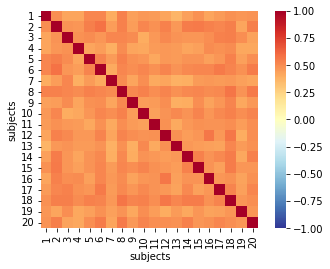

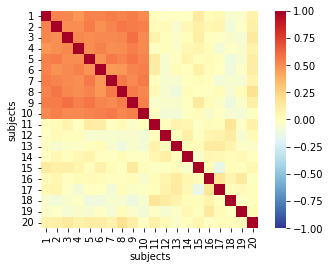

In [8]:
# Visualize the correlation matrix for one voxel
isc_matrix = squareform(iscs[:, 0])
np.fill_diagonal(isc_matrix, 1)
sns.heatmap(isc_matrix, cmap="RdYlBu_r", vmin=-1, vmax=1, square=True, 
            xticklabels=range(1, 21), yticklabels=range(1, 21))
plt.xlabel('subjects')
plt.ylabel('subjects')
plt.show()

# Create noisier data
noisy_data = np.dstack((np.dstack((
    simulated_timeseries(n_subjects // 2, n_TRs,
                         n_voxels=n_voxels, noise=1))),
                        np.dstack((
    simulated_timeseries(n_subjects // 2, n_TRs,
                         n_voxels=n_voxels, noise=5)))))

# Recompute ISC and visualize data with noisy subjects
noisy_iscs = isc(noisy_data, pairwise=True)
isc_matrix = squareform(noisy_iscs[:, 0])
np.fill_diagonal(isc_matrix, 1)
sns.heatmap(isc_matrix, cmap="RdYlBu_r", vmin=-1, vmax=1, square=True, 
            xticklabels=range(1, 21), yticklabels=range(1, 21))
plt.xlabel('subjects')
plt.ylabel('subjects')
plt.show()

### Leave-one-out approach
Instead of computing ISCs between each pair of subjects, for each subject we can compute the ISC between that subject and the average of all other subjects. Notice that the observed ISC values are typically higher in the leave-one-out approach due to computing correlations between the left-out subject and the cleaner averaged time series from the remaining subjects.

In [9]:
# Leave-one-out approach
iscs = isc(data, pairwise=False)

# Check shape of output ISC values
print(f"ISC values shape = {iscs.shape} \ni.e., {iscs.shape[0]} "
      f"left-out subjects and {iscs.shape[1]} voxel(s)"
      f"\nMinimum ISC = {np.amin(iscs):.3f}; "
      f"maximum ISC = {np.amax(iscs):.3f}")

ISC values shape = (20, 1000) 
i.e., 20 left-out subjects and 1000 voxel(s)
Minimum ISC = 0.559; maximum ISC = 0.784


## ISFC analysis
Rather than computing ISCs for corresponding voxels across participants, we can instead compute ISCs between all voxels to measure functional integration (i.e., connectivity). This method is called intersubject functional correlation (ISFC) analysis ([Simony et al., 2016](https://doi.org/10.1038/ncomms12141)). Using the `vectorize_isfcs` option, we can either return a tuple containing the condensed off-diagonal ISFC values and the diagonal ISC values or the square (redundant) ISFC values. If `vectorize_isfcs=True` (the default), the first array in the tuple contains the off-diagonal ISFC values for each pair of voxels as condensed by `scipy.spatial.distance.squareform` and is shaped `n_subjects` (or `n_pairs`) by `n_connections` where
```
n_connections = n_voxels * (n_voxels - 1) / 2
```
The second array in the tuple is the diagonal values shaped `n_subjects` (or `n_pairs`) by `n_voxels`. If `vectorize_isfcs=False`, we get a 3-dimensional array containing the square (redundant) ISFC and ISC values, shaped `n_subjects` (or `n_pairs`) by `n_voxels` by `n_voxels`.  If a `summary_statistic` is supplied, or only two subjects are input, the singleton first dimension is removed.

In [10]:
# Compute ISFCs using leave-one-out approach
isfcs, iscs = isfc(data, pairwise=False, vectorize_isfcs=True)

# Check shape of output ISFC values
print(f"ISFC output shape = {isfcs.shape}\ni.e., {isfcs.shape[0]} "
      f"left-out subjects by {isfcs.shape[1]} connections (i.e., voxel pairs)"
      f"\nISCs output shape = {iscs.shape}\ni.e., {iscs.shape[0]} "
      f"left-out subjects by {iscs.shape[1]} voxels")

ISFC output shape = (20, 499500)
i.e., 20 left-out subjects by 499500 connections (i.e., voxel pairs)
ISCs output shape = (20, 1000)
i.e., 20 left-out subjects by 1000 voxels


Alternatively, we can retain the (redundant) structure of the ISFC matrices using `vectorize_isfcs=False` to yield a 3-dimensional array of shape `n_subjects` by `n_voxels` by `n_voxels`:

In [11]:
# Compute ISFCs using leave-one-out approach
isfcs = isfc(data, pairwise=False, vectorize_isfcs=False)

# Check shape of output ISFC values
print(f"ISFC output shape = {isfcs.shape}\ni.e., {isfcs.shape[0]} "
      f"left-out subjects by {isfcs.shape[1]} voxels by {isfcs.shape[2]} "
      "voxels")

ISFC output shape = (20, 1000, 1000)
i.e., 20 left-out subjects by 1000 voxels by 1000 voxels


We can also supply a `summary_statistic` to collapse the ISFC values over left-out subjects or pairs of subjects:

In [12]:
# Compute ISFCs using leave-one-out approach with mean
isfcs, iscs = isfc(data, pairwise=False, summary_statistic='mean',
                   vectorize_isfcs=True)

# Check shape of output ISFC values
print(f"Mean ISFC output shape = {isfcs.shape}\ni.e., {isfcs.shape[0]} "
      f"connections (i.e., voxel pairs)"
      f"\nMean ISC output shape = {iscs.shape}\ni.e., {iscs.shape[0]} "
      "voxels")

Mean ISFC output shape = (499500,)
i.e., 499500 connections (i.e., voxel pairs)
Mean ISC output shape = (1000,)
i.e., 1000 voxels


Finally, we can visualize the matrix of mean (or median) ISFC values. If we used `vectorize_isfcs=True`, we'll first need to apply `squareform_isfc` the ISFC (and ISC) values. The diagonal blocks represent the 10 artificial "networks" in our simulated data; the 100 voxels in each network are highly correlated with each other and largely uncorrelated with voxels in other networks.

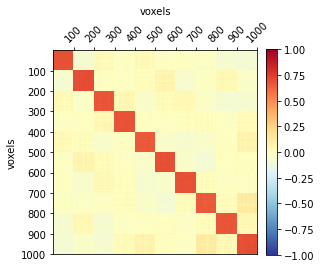

In [13]:
# Recompute mean ISFCs
isfcs, iscs = isfc(data, pairwise=False, summary_statistic='mean',
                   vectorize_isfcs=True)

# Convert these to a square representation
isfcs = squareform_isfc(isfcs, iscs)

# Visual mean ISFC matrix
plt.matshow(isfcs, cmap="RdYlBu_r", vmin=-1, vmax=1)
plt.grid(False)
plt.xticks(np.arange(0, 1001, 100)[1:], np.arange(100, 1001, 100),
           rotation=45)
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')
plt.yticks(np.arange(0, 1001, 100)[1:], np.arange(100, 1001, 100))
plt.xlabel('voxels')
plt.ylabel('voxels')
ax = plt.gca()
plt.colorbar(fraction=0.046, pad=0.04);

## Real fMRI data
Next, we'll  download a publicly available fMRI dataset and run an ISC analysis. This dataset comprises fMRI data for 20 subjects listening to the spoken story [Pie Man](https://themoth.org/stories/pie-man) by Jim O'Grady (archived on the [Princeton DataSpace](https://dataspace.princeton.edu/jspui/handle/88435/dsp01dz010s83s)). Note that we use 20 subjects to minimize computational demands for this tutorial and recommend larger sample sizes for publication. The gzipped data archive file is ~1.5 GB in size, and may take a couple minutes to download and unzip. The functional data were acquired with 3 x 3 x 4 mm voxels and 1.5 s TRs. Data were preprocessed using [fMRIPrep](https://fmriprep.readthedocs.io/en/stable/) ([Esteban et al., 2018](https://doi.org/10.1038/s41592-018-0235-4)), including spatial normalization to MNI space (the T1-weighted [ICBM 2009c Nonlinear Asymmetric template](http://nist.mni.mcgill.ca/?p=904)). The data were then smoothed to 6 mm FWHM using [AFNI](https://afni.nimh.nih.gov/)'s [3dBlurToFWHM](https://afni.nimh.nih.gov/pub/dist/doc/program_help/3dBlurToFWHM.html) ([Cox, 1996](https://doi.org/10.1006/cbmr.1996.0014)). The following confound variables were regressed out using [3dTproject](https://afni.nimh.nih.gov/pub/dist/doc/program_help/3dTproject.html): six head motion parameters (and their first derivatives), framewise displacement, six prinicipal components from an anatomical mask of cerebrospinal fluid (CSF) and white matter, sine/cosine bases for high-pass filtering (cutoff: 0.00714 Hz; 140 s), as well as a linear and quadratic trends. The anatomical template and a brain mask (i.e., excluding skull) are supplied as well. These have been resampled to match resolution of the functional images.

### Loading MRI data
We'll use NiBabel as well as BrainIAK's `io` and `image` functionality to load the functional data and apply a brain mask.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Import functions helpful for managing file paths
from glob import glob
from os.path import join

data_dir = '/content/drive/MyDrive/pieman-isc-tutorial'

# Filenames for MRI data; gzipped NIfTI images (.nii.gz)
func_fns = glob(join(data_dir, ('sub-*_task-pieman_space-MNI152NLin2009cAsym'
                                '_desc-tproject_bold.nii.gz')))
mask_fn = join(data_dir, 'MNI152NLin2009cAsym_desc-brain_mask.nii.gz')
mni_fn = join(data_dir, 'MNI152NLin2009cAsym_desc-brain_T1w.nii.gz')

#use only the first 4 subject 
func_fns = func_fns[:4]

# Load a NIfTI of the brain mask as a reference Nifti1Image
ref_nii = nib.load(mask_fn)

# Load functional images and masks using brainiak.io
func_imgs = load_images(func_fns)
mask_img = load_boolean_mask(mask_fn)

# Get coordinates of mask voxels in original image
mask_coords = np.where(mask_img)

# Apply the brain mask using brainiak.image
masked_imgs = mask_images(func_imgs, mask_img)

# Collate data into a single TR x voxel x subject array
orig_data = MaskedMultiSubjectData.from_masked_images(masked_imgs,
                                                      len(func_fns))

The data from each subject are stacked along the third dimension, yielding a `n_TRs` by `n_voxels` by `n_subjects` array. The functional acquisition originally included 13 s of music and 2 s of silence prepended to the story stimulus and an additional 13 s of silence after the story (450 s or 300 TRs in total). These segments as well as the first 12 s (8 TRs) after story onset can be discarded to minimize stimulus onset/offset effects. We may also opt to z-score the time series for each voxel.

In [4]:
print(f"Original fMRI data shape: {orig_data.shape} "
      f"\ni.e., {orig_data.shape[0]} time points, {orig_data.shape[1]} voxels, "
      f"{orig_data.shape[2]} subjects")

# Trim off non-story TRs and 12 s post-onset
data = orig_data[18:-8, ...]

print(f"Trimmed fMRI data shape: {data.shape} "
      f"\ni.e., {data.shape[0]} time points, {data.shape[1]} voxels, "
      f"{data.shape[2]} subjects")

# Z-score time series for each voxel
data = zscore(data, axis=0)

Original fMRI data shape: (300, 52429, 4) 
i.e., 300 time points, 52429 voxels, 4 subjects
Trimmed fMRI data shape: (274, 52429, 4) 
i.e., 274 time points, 52429 voxels, 4 subjects


### ISC analysis
Next, we'll run a leave-one-out ISC analysis on the preprocessed fMRI data, including all voxels in the brain mask—this may take a few minutes. Note that some voxels with no variance over time for one or more subjects were included in the brain mask due to the limited field of view during EPI acquisition and susceptibility artifacts (signal dropout). This yields NaN (not a number) values. Here, we'll use set `tolerate_nans` to `0.8` to ensure that, when computing the averaging time series for *N*–1 subjects in the leave-one-out approach, only voxels with >= 80% of subjects have non-NaN values are included.

In [46]:
# Leave-one-out approach
iscs = isc(data, pairwise=False) # , tolerate_nans=.8


# Check shape of output ISC values
print(f"ISC values shape = {iscs.shape} \ni.e., {iscs.shape[0]} "
      f"left-out subjects and {iscs.shape[1]} voxel(s)")

/content/isc_standalone.py:190: RuntimeWarning: Mean of empty slice
  mean(np.delete(data, s, axis=2), axis=2)))


ISC values shape = (4, 52429) 
i.e., 4 left-out subjects and 52429 voxel(s)


Since we didn't supply a `summary_statistic` in the `isc` call, we get an ISC value for each left-out subject (we'll need ISCs for each subject in the subsequent statistical test). If we want to preliminarily inspect the mean (or median) ISCs, we can apply the `brainiak.isc.compute_summary_statistic` function afterward. Note that if we specifed a `summary_statistic` in the `isc` call, the `isc` function would simply use `compute_summary_statistic` internally.



In [22]:
# Compute mean ISC (with Fisher transformation)
mean_iscs = compute_summary_statistic(iscs, summary_statistic='mean', axis=0)

print(f"ISC values shape = {mean_iscs.shape} \ni.e., {mean_iscs.shape[0]} "
      f"mean value across left-out subjects and {iscs.shape[1]} voxel(s)"
      f"\nMinimum mean ISC across voxels = {np.nanmin(mean_iscs):.3f}; "
      f"maximum mean ISC across voxels = {np.nanmax(mean_iscs):.3f}")


# Compute median ISC
median_iscs = compute_summary_statistic(iscs, summary_statistic='median',
                                        axis=0)

print(f"ISC values shape = {median_iscs.shape} \ni.e., {median_iscs.shape[0]} "
      f"median value across left-out subjects and {iscs.shape[1]} voxel(s)"
      f"\nMinimum median ISC across voxels = {np.nanmin(median_iscs):.3f}; "
      f"maximum median ISC across voxels = {np.nanmax(median_iscs):.3f}")

ISC values shape = (52429,) 
i.e., 52429 mean value across left-out subjects and 52429 voxel(s)
Minimum mean ISC across voxels = -0.203; maximum mean ISC across voxels = 0.581
ISC values shape = (52429,) 
i.e., 52429 median value across left-out subjects and 52429 voxel(s)
Minimum median ISC across voxels = -0.200; maximum median ISC across voxels = 0.615


/content/isc_standalone.py:524: RuntimeWarning: Mean of empty slice
  statistic = np.tanh(np.nanmean(np.arctanh(iscs), axis=axis))
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1120: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


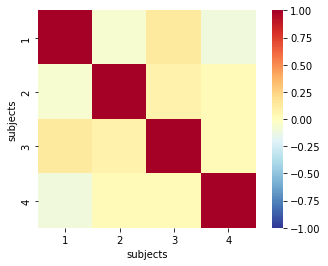

In [52]:
# Leave-one-out approach
iscs = isc(data, pairwise=True, tolerate_nans=.8) 


# Visualize the correlation matrix for one voxel
isc_matrix = squareform(iscs[:, 5000])
np.fill_diagonal(isc_matrix, 1)
sns.heatmap(isc_matrix, cmap="RdYlBu_r", vmin=-1, vmax=1, square=True, 
            xticklabels=range(1, 5), yticklabels=range(1, 5))
plt.xlabel('subjects')
plt.ylabel('subjects')
plt.show()

In [9]:
data.shape

(274, 52429, 4)

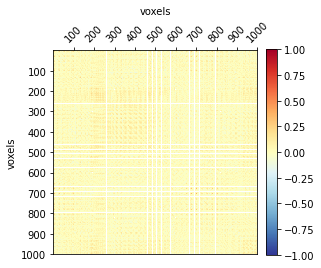

In [12]:
# Recompute mean ISFCs
isfcs, iscs = isfc(data[:, 2000:3000,:], pairwise=False, summary_statistic='mean',
                   vectorize_isfcs=True)

# Convert these to a square representation
isfcs = squareform_isfc(isfcs, iscs)

# Visual mean ISFC matrix
plt.matshow(isfcs, cmap="RdYlBu_r", vmin=-1, vmax=1)
plt.grid(False)
plt.xticks(np.arange(0, 1001, 100)[1:], np.arange(100, 1001, 100),
           rotation=45)
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')
plt.yticks(np.arange(0, 1001, 100)[1:], np.arange(100, 1001, 100))
plt.xlabel('voxels')
plt.ylabel('voxels')
ax = plt.gca()
plt.colorbar(fraction=0.046, pad=0.04)

### Visualizing results
Finally, to visualize the significant ISC values, we must first reformat the 2-dimensional masked array into a 3-dimensional NIfTI image. We'll use an arbitrary reference NIfTI image `ref_nii` (the brain mask) to assign affine and header information correctly.

In [34]:
subject_num = 2
# Create empty 3D image and populate
# with thresholded ISC values
isc_img = np.full(ref_nii.shape, np.nan)
isc_img[mask_coords] = iscs[subject_num,:]

# Convert to NIfTI image
isc_nii = nib.Nifti1Image(isc_img, ref_nii.affine, ref_nii.header)

In [35]:
from nilearn.plotting import plot_stat_map
%matplotlib inline

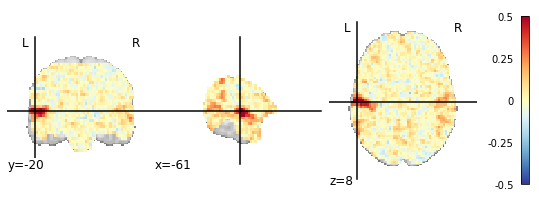

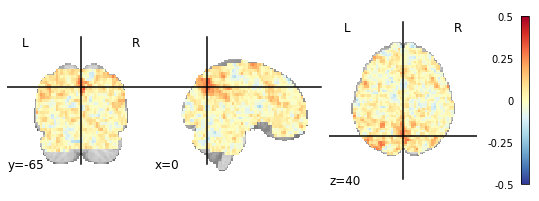

In [36]:
# Plot slices at coordinates -61, -20, 8
plot_stat_map(
    isc_nii,
    cmap='RdYlBu_r',
    vmax=.5,
    cut_coords=(-61, -20, 8))

# Plot slices at coordinates 0, -65, 40
plot_stat_map(
    isc_nii,
    cmap='RdYlBu_r',
    vmax=.5,
    cut_coords=(0, -65, 40))
plt.show()